In [270]:
import numpy
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import os
from PIL import Image
import re
import string
import tweepy

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
nltk.download("vader_lexicon")
nltk.download("stopwords")

/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/tdelatte/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tdelatte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scrape Tweets with Tweepy

In [299]:
TWITTER_KEY = os.environ.get("TWITTER_KEY")
TWITTER_SECRET_KEY = os.environ.get("TWITTER_SECRET_KEY")

In [300]:
# Authenticate
auth = tweepy.AppAuthHandler(TWITTER_KEY, TWITTER_SECRET_KEY)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

TweepError: Expected token_type to equal "bearer", but got None instead

In [42]:
TRACK_WORD = "HongKongProtests"

SEARCH_QUERY = TRACK_WORD + " -filter:retweets"
LANG = "en"

BATCH_SIZE = 100 
MAX_TWEETS = 100000

Part of the code below was inspired by the code from: https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively.

Unfortunately, Twitter' free tier API use is rather limited. We can only request 45.000 tweets per 15 minutes window. Much to my surprise, only tweets from the last 7 days can be scraped. 

In [45]:
tweet_lst = []

# No upper limit, start from the most recent tweet matching the search query
max_id = -10000000000

# Initialize number of tweets
tweetCount = 0

while tweetCount < MAX_TWEETS:
    try:
        if (max_id <= 0):
            new_tweets = api.search(q=SEARCH_QUERY, count=BATCH_SIZE, lang=LANG)
        else:
            new_tweets = api.search(q=SEARCH_QUERY, count=BATCH_SIZE,
                                        lang=LANG, max_id=str(max_id - 1))
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
            
          # fixup search query to get topic
          topic = SEARCH_QUERY[:SEARCH_QUERY.find('-')].capitalize().strip()
          
          # fixup date
          tweetDate = tweet.created_at.date()
          
          tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, tweet.created_at])

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("error : " + str(e))
        break

print(f"Downloaded {tweetCount} tweets")

Downloaded 95 tweets
Downloaded 195 tweets
Downloaded 295 tweets
Downloaded 395 tweets
Downloaded 495 tweets
Downloaded 593 tweets
Downloaded 676 tweets
Downloaded 771 tweets
Downloaded 870 tweets
Downloaded 970 tweets
Downloaded 1065 tweets
Downloaded 1156 tweets
Downloaded 1253 tweets
Downloaded 1353 tweets
Downloaded 1453 tweets
Downloaded 1549 tweets
Downloaded 1642 tweets
Downloaded 1742 tweets
Downloaded 1842 tweets
Downloaded 1942 tweets
Downloaded 2042 tweets
Downloaded 2142 tweets
Downloaded 2242 tweets
Downloaded 2331 tweets
Downloaded 2417 tweets
Downloaded 2504 tweets
Downloaded 2596 tweets
Downloaded 2686 tweets
Downloaded 2771 tweets
Downloaded 2850 tweets
Downloaded 2938 tweets
Downloaded 2996 tweets
Downloaded 3063 tweets
Downloaded 3159 tweets
Downloaded 3246 tweets
Downloaded 3346 tweets
Downloaded 3442 tweets
Downloaded 3542 tweets
Downloaded 3642 tweets
Downloaded 3717 tweets
Downloaded 3800 tweets
Downloaded 3900 tweets
Downloaded 3998 tweets
Downloaded 4077 tweets

## Preprocess the data
We load the data into a Pandas DataFrame for easier processing.

In [46]:
# load it into a pandas dataframe
tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet',
                                            'like_count', 'reply_count', 'retweet_count', 'created_at'])

# Export to csv
tweet_df.to_csv('tweets.csv')

/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,created_at
0,2020-05-29,Hongkongprotests,1266318552392294402,WolfNW,WolfNW,Having watched @CNN’s @OmarJimenez and his crew get arrested by the #Minnesota #StatePolice for peacefully reportin… https://t.co/636WQrMpre,0,0,0,2020-05-29 10:40:44
1,2020-05-29,Hongkongprotests,1266315298811985921,planetdedehk,planetdede,"As #CarrieLam now only does the CCP’s admin work, why is she still being paid the CEO’s salary?\n\n#StandWithHongKong… https://t.co/mnLIziv8wx",1,0,0,2020-05-29 10:27:48
2,2020-05-29,Hongkongprotests,1266314950533767170,akkis123,Akshay Shah अक्षय शाह,@indiatvnews #Chinazi #ChinaLiedAndPeopleDied #HongKongProtests I support Hongkong. Chinese are worst creatures on earth,0,0,0,2020-05-29 10:26:25
3,2020-05-29,Hongkongprotests,1266314609553625093,yourtitakate,k8 wants THE CAVE SCENE,"I hope people are watching Minnesota, Hong Kong, and the Philippines. If you’ve ever needed proof that THE POLICE A… https://t.co/iEdGoQFQeH",7,0,4,2020-05-29 10:25:04
4,2020-05-29,Hongkongprotests,1266314516154834944,shrimpmaruchan,sad noodle,"Here’s a video for more info, STAY SAFE OUT THERE \nNO JUSTICE NO PEACE \n#BlackLivesMatters #BLM #JusticeForFloyd… https://t.co/FfEny49wU3",0,0,0,2020-05-29 10:24:42


In [53]:
def clean_tweet(text):
    """Preprocess the text of the tweets by keeping only English relevant words ."""
    if text:
        text = re.sub("RT @[\w]*:","",text) # remove rewteets
        text = re.sub("@[\w]*","",text) # remove mentions
        text = re.sub("https?://[A-Za-z0-9./]*","", text) # remove URLs
        text = re.sub("\n","",text) # remove escape sequences
        text = re.sub(r'#([^\s]+)', '', text) # remove hashtags 
        text = text.lower() # convert to lowercase
        # remove punctuation
        text = [word.strip(string.punctuation) for word in text.split(" ")]
        # remove numbers
        text = [word for word in text if not any(l.isdigit() for l in word)]
        stop = stopwords.words('english') # remove stop words
        text = [x for x in text if x not in stop]
        text = [t for t in text if len(t) > 1] # remove 1-letter words
        text = " ".join(text) # join all text 
    else:
        text = ""
    return text

In [48]:
def remove_chinese_words(text):
    """Remove all chinese words from a text"""
    # english words
    en_list = re.findall(u"[^\u4E00-\u9FA5\u3000-\u303F]", str(text))
    
    # Remove word from the list, if not english
    for w in text:
        if w not in en_list:
            text = text.replace(w, "")
    return text

In [67]:
# Apply preprocessing functions to our data
tweets_clean = tweet_df.copy()
tweets_clean["tweet"] = tweets_clean["tweet"].apply(clean_tweet)
tweets_clean["tweet"] = tweets_clean["tweet"].apply(remove_chinese_words)
tweets_clean["created_at"] = tweets_clean["created_at"].apply(pd.to_datetime)
tweets_clean.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,created_at
0,2020-05-29,Hongkongprotests,1266318552392294402,WolfNW,WolfNW,watched ’s crew get arrested peacefully reportin…,0,0,0,2020-05-29 10:40:44
1,2020-05-29,Hongkongprotests,1266315298811985921,planetdedehk,planetdede,ccp’s admin work still paid ceo’s salary,1,0,0,2020-05-29 10:27:48
2,2020-05-29,Hongkongprotests,1266314950533767170,akkis123,Akshay Shah अक्षय शाह,support hongkong chinese worst creatures earth,0,0,0,2020-05-29 10:26:25
3,2020-05-29,Hongkongprotests,1266314609553625093,yourtitakate,k8 wants THE CAVE SCENE,hope people watching minnesota hong kong philippines you’ve ever needed proof police a…,7,0,4,2020-05-29 10:25:04
4,2020-05-29,Hongkongprotests,1266314516154834944,shrimpmaruchan,sad noodle,here’s video info stay safe justice peace,0,0,0,2020-05-29 10:24:42


## Word Cloud
First of all, we generate a Word Cloud that shows in a visual and intuitive way the most used words in the Honk Kong protests tweets. 

In [264]:
# Use the HK skyline as a mask for our wordcloud
mask = np.array(Image.open("HK_skyline.jpg"))

# Remove uninformative frequent words
stop_words = ["hong", "kong", "hongkong", "people"] + list(STOPWORDS)

# Instance of WordCloud object
wordcloud = WordCloud(
    max_words=100,
    height=300,
    width=800,
    background_color = 'white',
    mask=mask,
    stopwords = stop_words,
    contour_width=1,
    contour_color="steelblue",
).generate(str(tweets_clean["tweet"]))

# Save the wordcloud to a png file
wordcloud.to_file("HK_wordcloud.png")

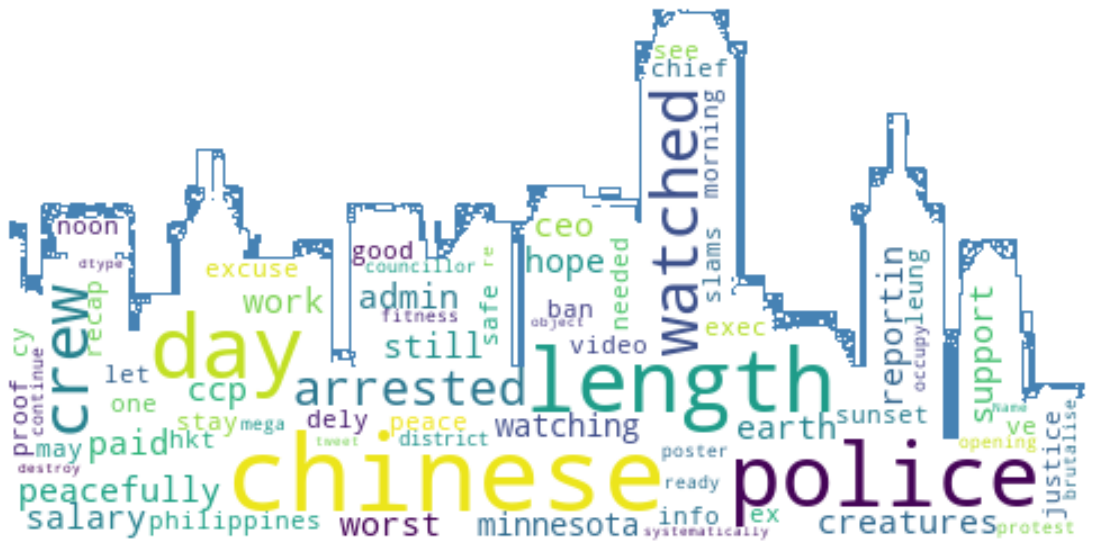

In [265]:
fig = plt.figure(1, figsize = (15, 15))
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation="bilinear")

The word cloud includes the 100 most frequent words. The more popular it is, the bigger its size in the Word Cloud is. 

We can easily relate some of the biggest words to the protests: watched, police, chinese, arrested, peacefully, protest, and so on.

It is nevertheless difficult to know whether these words are used in a positive or negative way towards the government or protesters. For this purpose, let's perform a sentiment analysis of the tweets.

## Sentiment Analysis
We will use here the NLTK library, and more particularly its SentimentIntensityAnalyzer.

In [68]:
# Create the SentimentIntensityAnalyzer object
sent = SentimentIntensityAnalyzer()
# Apply its polarity_score method 
tweets_clean["sentiment"] = tweets_clean["tweet"].apply(lambda x: sent.polarity_scores(x))

In [70]:
# Keep only the compound scores under the column "Sentiment"
tweets_sentiment = pd.concat([tweets_clean.drop(["sentiment"], axis = 1),
                              tweets_clean["sentiment"].apply(pd.Series)], axis = 1)

In [72]:
# a glance at the data
tweets_sentiment.head()

,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,created_at,neg,neu,pos,compound
0,2020-05-29,Hongkongprotests,1266318552392294402,WolfNW,WolfNW,watched ’s crew get arrested peacefully reportin…,0,0,0,2020-05-29 10:40:44,0.27,0.435,0.296,0.0772
1,2020-05-29,Hongkongprotests,1266315298811985921,planetdedehk,planetdede,ccp’s admin work still paid ceo’s salary,1,0,0,2020-05-29 10:27:48,0.00,1.000,0.000,0.0000
2,2020-05-29,Hongkongprotests,1266314950533767170,akkis123,Akshay Shah अक्षय शाह,support hongkong chinese worst creatures earth,0,0,0,2020-05-29 10:26:25,0.38,0.370,0.250,-0.3400
3,2020-05-29,Hongkongprotests,1266314609553625093,yourtitakate,k8 wants THE CAVE SCENE,hope people watching minnesota hong kong philippines you’ve ever needed proof police a…,7,0,4,2020-05-29 10:25:04,0.00,0.805,0.195,0.4404
4,2020-05-29,Hongkongprotests,1266314516154834944,shrimpmaruchan,sad noodle,here’s video info stay safe justice peace,0,0,0,2020-05-29 10:24:42,0.00,0.290,0.710,0.8689


In [161]:
# Focus on 'compound' scores
sentiment_class_list = []

# loop through all tweets
for i in range(0, len(tweets_sentiment)):
    # current sentiment' score:
    compound = tweets_sentiment.iloc[i,:]["compound"]
    # divide in 5 classes for easier interpretation
    if (compound <= 1.0 and compound >= 0.55):
        sentiment_class_list.append(5)
    elif (compound < 0.55 and compound >= 0.10):
        sentiment_class_list.append(4)
    elif (compound < 0.10 and compound > -0.10):
        sentiment_class_list.append(3)
    elif (compound <= -0.10 and compound > -0.55):
        sentiment_class_list.append(2)
    elif (compound <= -0.55 and compound >= -1.00):
        sentiment_class_list.append(1)
        
# new column in our data
tweets_sentiment["sentiment_class"] = sentiment_class_list

In [162]:
# check whether compound score and sentiment match
tweets_sentiment.iloc[0:5, :][["compound", "sentiment_class"]]

,compound,sentiment_class
0,0.0772,3
1,0.0000,3
2,-0.3400,2
3,0.4404,4
4,0.8689,5


Let's have a look at some of the tweets and see the difference between neutral, positive and negative tweets.

In [164]:
# Randomly chosen tweets with a negative sentiment
tweets_sentiment[(tweets_sentiment['sentiment_class'] == 1) | 
              (tweets_sentiment['sentiment_class'] == 2)].sample(n=10)[['sentiment_class', 'tweet']]

10 random negative original tweets and their sentiment classes:


,sentiment_class,tweet
6377,1,hk police suddenly arrested youngster trying argue
3422,2,lunch time hong kong today arbitrary arrests excessive force done citi…
8089,1,rally forced stop since police fired tear gas used water cannon stop us t…
5245,2,china disgusting
2152,1,shit economic consequences move resonate across asia world hk's future never uncert…
2061,2,hey late party declared longer separate murderous bastard…
3263,1,today’s lunchtime hong kong police fired pepper bullets towards unarmed citizens appearing hit an…
4325,2,may hong kongppl detained pedestrian bridge cable news
6851,2,change density go protesting choice
2941,1,pm police dispersed people russell street fired pepper spray slow-moving eld…


In [165]:
# Randomly chosen tweets with a positive sentiment
tweets_sentiment[(tweets_sentiment['sentiment_class'] == 4) | 
              (tweets_sentiment['sentiment_class'] == 5)].sample(n=20)[['sentiment_class', 'tweet']]

20 random positive original tweets and their sentiment classes:


,sentiment_class,tweet
2886,5,fucking hellwhat dowhy fucking police treat like thathe dont fucking deserve why…
599,4,dear you’re lily livered invertebrate jellies need kick international relations back…
10863,4,passed article foreign investments hong kong longer safeguarded whenever investment…
5285,4,chilling see though would see years coming true space…
8096,5,freedom free
6350,4,see fighting freedom amp see thugs belong in…
2769,4,hk unedinably becoming police state thanks controlled police
6498,4,please take little time read 🙏🏻
8242,4,still choose march us today despite knowing risks arrested shadow…
5848,4,absolutely free world must join hands fight amp defeat like nazi amp ussr f…


Distriubtion of negative/neutral/positive tweets

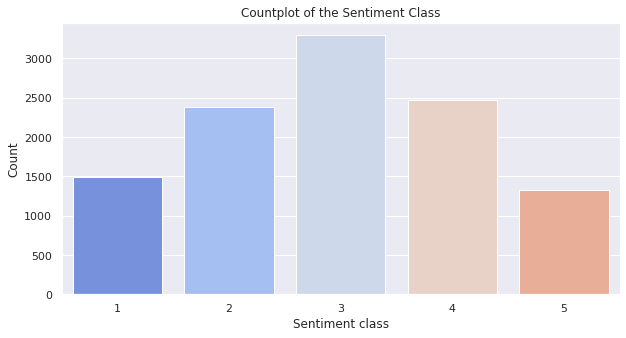

In [271]:
# plot a countplot of the sentiment_class
plt.figure(figsize = (10,5))
sns.set_palette("coolwarm")
sns.countplot(tweets_sentiment["sentiment_class"])
plt.title("Countplot of the Sentiment Class")
plt.xlabel("Sentiment class")
plt.ylabel("Count")
plt.savefig("countplot.png")

Sentiment analysis in the context of protests may be misleading. Indeed, the sentiment of a tweet, whether it is positive or negative, can relate either to the authorities or to the protesters. Applying sentiment analysis to tweets/reviews about a restaurant (for example) are rather unambiguous because we know the object of the sentiment.

This is why these results are difficult to interpret.

Some further analysis could include multi-dimensional sentiment analysis, with dimensions such as: fearful, assertice, sad, angry,... For this task, the BERT model could be used.

## Timeseries Visualization

In [269]:
print(f"First tweet: {tweets_clean['created_at'].min()} \nLatest tweet: 
      {tweets_clean['created_at'].max()}\nTime Elapsed: 
      {tweets_clean['created_at'].max() - tweets_clean['created_at'].min()}")

First tweet: 2020-05-20 20:37:44 
Latest tweet: 2020-05-29 10:40:44
Time Elapsed: 8 days 14:03:00


In [296]:
# divide the 8 days in 8 hours blocks
TIME_WINDOW = "8H"

# create a timeseries dataframe with the counts per time window
time_series = tweets_sentiment[["id", "sentiment_class",
                                "created_at"]].groupby([pd.Grouper(key="created_at", 
                                                                   freq=TIME_WINDOW),"sentiment_class"]).count()

# set count as index and rename the column
time_series = time_series.reset_index().rename(columns={"id":"count"})

In [297]:
# divide sentiment in 3 categories: Positive, Neutral and Negative
time_series.loc[time_series.sentiment_class == 1, "sentiment_class" ] = "Negative"
time_series.loc[time_series.sentiment_class == 2, "sentiment_class" ] = "Negative"
time_series.loc[time_series.sentiment_class == 3, "sentiment_class" ] = "Neutral"
time_series.loc[time_series.sentiment_class == 4, "sentiment_class" ] = "Positive"
time_series.loc[time_series.sentiment_class == 5, "sentiment_class" ] = "Positive"

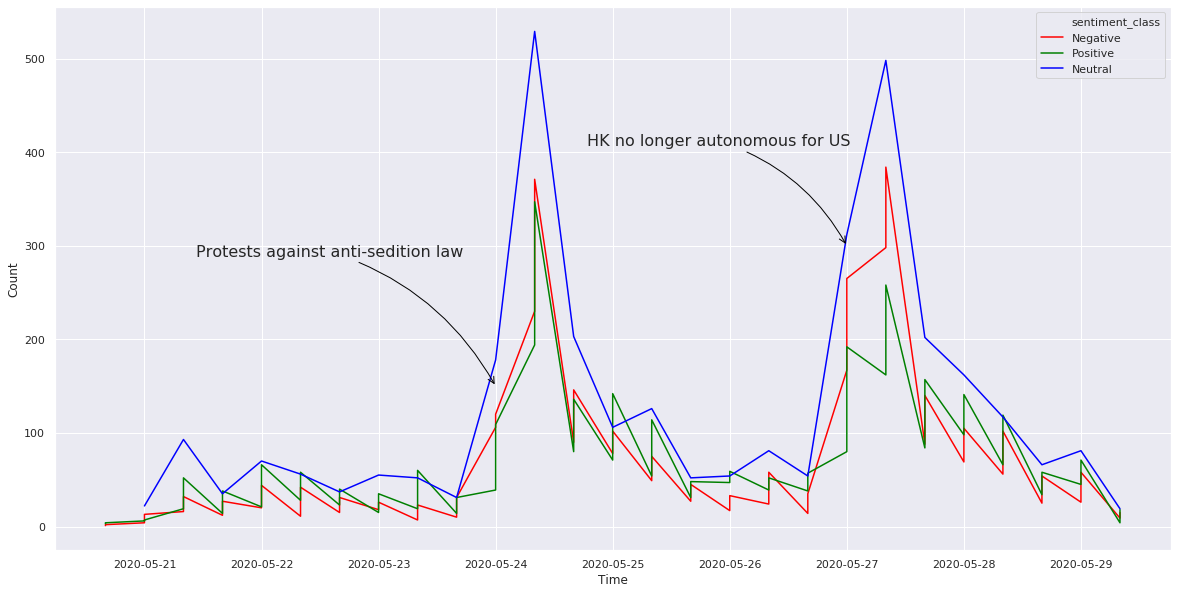

In [298]:
# plot the tweets counts per sentiment class through time
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(x=time_series["created_at"], y=time_series["count"],
                   hue=time_series["sentiment_class"], estimator=None,
                   palette={"Negative": "red", "Positive": "green", "Neutral": "blue"})

# Put labels on axes
ax.set_xlabel("Time")
ax.set_ylabel("Count")

# Select appropriate moment for the annotations
first_anno = time_series.created_at[50]
second_anno = time_series.created_at[95]

# Add annotations to the plot
ax.annotate("Protests against anti-sedition law", xy=(first_anno, 150),  xycoords='data',
            xytext=(-300, 130), size=16, textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color="black", connectionstyle="arc3,rad=-0.2"))

ax.annotate("HK no longer autonomous for US", xy=(second_anno, 300),  xycoords='data',
            xytext=(-260, 100), size=16, textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color="black", connectionstyle="arc3,rad=-0.2"))

# Save the plot to a file
plt.savefig("timeseries.png")